## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('landing_page == "new_page" and group != "treatment"').head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1


In [8]:
df.query('landing_page == "new_page" and group != "treatment"').shape

(1928, 5)

In [9]:
df.query('landing_page != "new_page" and group == "treatment"').head()

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [10]:
df.query('landing_page != "new_page" and group == "treatment"').shape

(1965, 5)

In [11]:
#The number of times the new_page and treatment don't match.
1928+1965

3893

In [12]:
df.groupby(['landing_page'])['group'].value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

f. Do any of the rows have missing values?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [15]:
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [16]:
df.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

In [17]:
df2 = (df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")'))
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [19]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [20]:
df2[df2['user_id'].duplicated(keep = False)]

#or df2[df2.user_id.duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [21]:
df2[df2['user_id'].duplicated(keep = False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [22]:
df2[df2['user_id'].duplicated(keep = False)].index

Int64Index([1899, 2893], dtype='int64')

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [23]:
df2 = df2.drop_duplicates('user_id')

In [24]:
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted


In [25]:
df2.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [26]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [27]:
df2.describe()

,user_id,converted
count,290584.000000,290584.000000
mean,788004.876222,0.119597
std,91224.735468,0.324490
min,630000.000000,0.000000
25%,709034.750000,0.000000
50%,787995.500000,0.000000
75%,866956.250000,0.000000
max,945999.000000,1.000000


In [28]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [29]:
df2_cont = df2.query('group =="control"')
df2_cont.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [30]:
df2_treat = df2.query('group =="treatment"')
df2_treat.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [31]:
(df2.query("landing_page == 'new_page'")).shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

#### My Answer

**No, there is not sufficient evidence to conclude that the new treatment page leads to more conversions.**

From the probability that an individual received the new page is around 0.5 and treatment group probability is 0.1188
So the probability that an individual received the new page is around 0.5 and control group probability is 0.1204

0.1204 that received the old_page were converted. 0.1188 that received the new_page were converted. Then, the new_page did not increase the conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### My Answer

$$H_0: p_{old} \geq p_{new}$$

$$H_1: p_{old} \lt p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [32]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [33]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [34]:
n_new = df2.query('group =="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [35]:
n_old = df2.query('group =="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [36]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
#Recheck
print(len(new_page_converted))

145310


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [39]:
#Recheck
print(len(old_page_converted))

145274


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [40]:
new_page_converted.mean() - old_page_converted.mean()

0.00073420552261251049

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [41]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [42]:
np.std(p_diffs)

0.0012088100437306587

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

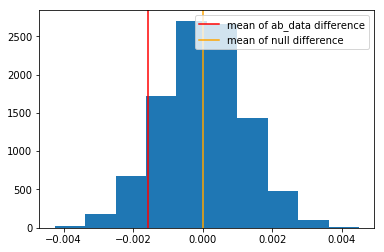

In [43]:
#low is the difference between treatment and control groups in ab_data
obs_diff  = df2_treat.converted.mean()-df2_cont.converted.mean() 

#High is the difference between treatment and control groups in null hypothesis
null_diff = (np.array(p_diffs)).mean()

plt.hist(p_diffs);
plt.axvline(x=obs_diff, c='red', label='mean of ab_data difference');
plt.axvline(x=null_diff, c='orange', label='mean of null difference');
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [44]:
#P-Value
(p_diffs > obs_diff).mean()

0.90459999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**My Answer**

In [45]:
# we failed to reject the null-hypothesis as our p_value is way higher
(p_diffs > obs_diff).mean() <= 0.05

False

The calculation of the part **j.** is p-value. The p-value is a value with even greater evidence against $H_0$, if the null hypothesis is true. 

In this case, p-value > $\alpha$ (0.8977>0.05). Therefore, the new page does not make the conversion rates better than the old page

________

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
import statsmodels.api as sm

convert_old = df2.query('group =="control" and converted == 1').shape[0]
convert_new = df2.query('group =="treatment" and converted == 1').shape[0]
n_old = df2.query('group =="control"').shape[0]
n_new = df2.query('group =="treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [48]:
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [49]:
z_score ,p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

print(z_score ,p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [50]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
# http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Calcul_P_Value.pdf
from scipy.stats import norm

print(norm.cdf(z_score))
# Tells us how significant our z-score is

# Critical Value
# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))
# PPF (q) of the standard normal distributionfor the probability (1 –α)
# Tells us what our critical value at 95% confidence is 

0.905058312759
1.64485362695


In [51]:
print('The z-score is:',z_score,',but in order to reject the null hypothesis, The z-score needs to exceed the level of:'
      ,norm.ppf(1-(0.05)),
     'since this was not the case, we failed to reject the null')

print('Our p-value is:', p_value)

The z-score is: 1.31092419842 ,but in order to reject the null hypothesis, The z-score needs to exceed the level of: 1.64485362695 since this was not the case, we failed to reject the null
Our p-value is: 0.905058312759


**My Answer**

A z-score (also called a standard score) gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is. So we have z-score = 1.31092419842 and critical value = 1.64485362695, which mean we fail to reject the null hypothesis. Thus, the new page does not make the rate better than the old page same as a part **j.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression** (binary variable: converted vs not converted)
___

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [52]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [53]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-28 14:56 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [54]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-28 14:56 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**My Answer.**

The p-value associated with ab_page is 0.19 and it is higher than 0.05 (0.19 > 0.05). Thus, the new page is not statistically significant.

From part II: the conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one-tailed test.

>$$H_1: p_{old} \lt p_{new}$$


From Part III, the conversion rate of the old_page is not equal to the conversion rate of the new_page. This assumes a two-tailed test.
>$$H_1: p_{old} \neq p_{new}$$

___

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**My Answer**

The advantages of considering adding other factors or explanatory variables in the regression model is that we can build more credibility with our models and may find factors or explanatory variables that can affect our models a lot that we hadn't anticipated.

The disadvantage of considering adding other factors or explanatory variables to the regression model is that we are more complicated to do the model and need to use the factors or explanatory variables carefully to avoid bias (Simpson's paradox).
___

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [55]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [56]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [57]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [58]:
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [59]:
df_new = df_new.rename(columns={"treatment": "ab_page"})
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [60]:
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,US,UK,CA,UK_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0


In [61]:
df_new['intercept'] = 1
lm_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])
results = lm_new.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [62]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-28 14:56 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
CA             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
CA_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [64]:
#1/e^ or e^ 
np.exp(results.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
CA            1.017682
UK_ab_page    1.081428
CA_ab_page    1.048001
dtype: float64

- The p-value from UK and CA are better than 0.05.
- (Old Pages) Users from United Kingdom are 1.011854 times more likely to convert than users from US.
- (Old Pages) Users from Canada are 1.017682 times more likely to convert than users from US.
- (New Pages) Users from United Kingdom are 1.081428 times more likely to convert than users from US.
- (New Pages) Users from Canada are 1.048001 times more likely to convert than users from US.
- There is not enough evidence that the new pages increases the conversion rate as compared to the old pages.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0